# Data Set Creation Notebook

This notebook creates the composite data set used in the Geocomputation module. You are welcome to add additional data sets for the purposes of the final assessment in the module if you so wish.

In [1]:
# Needed on a Mac
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import requests
import pandas as pd
import geopandas as gpd

In [3]:
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

import zipfile
def extract_all(file_path):
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall('.')
    zip_ref.close()

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))
    
def compress_all(srcdir, name):
    zipf = zipfile.ZipFile(name + '.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir(srcdir, zipf)
    zipf.close()

## London

Useful for filtering down the data sets that we've downloaded from OSOpen.

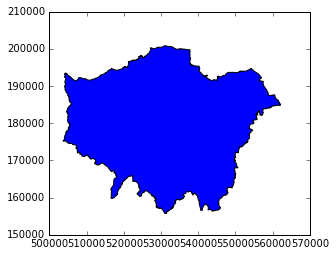

In [4]:
fpath = os.path.join('London','London.shp')
if not (os.path.exists(fpath) and os.path.isfile(fpath)):
    print("Unpacking...")
    extract_all(os.path.join('Data','London.zip'))
ldn = gpd.read_file(fpath)
ldn.crs = {'init': u'epsg:27700'}
ldn.plot()

## Lower Super Output Area Data

Downloaded from the [London Data Store](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london), with the Output Area shapefile extracted and re-compressed to save space on GitHub. 

In [5]:
# Extract Output Areas
fpath = os.path.join('LSOA','LSOA_2011_London_gen_MHW.shp')
if not (os.path.exists(fpath) and os.path.isfile(fpath)):
    print("Unpacking...")
    extract_all(os.path.join('Data','LSOA.zip'))
lsoa = gpd.read_file(fpath)
lsoa.crs = {'init': u'epsg:27700'}

# Stash a copy of original geometry and the centroids
# since we'll need both again
#lsoa['outlines']  = lsoa.geometry
#lsoa['centroids'] = lsoa.geometry.centroid

In [6]:
# Notice the range of geographies to which we can now join:
# LSOA, MSOA, LA, and Region
# We've also got some very simple, basic measures such as
# population density, usual residents, and average household
# size.
lsoa.head(2)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.0919998939 182011.23, 532162...."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.8130000263 181786.891000028, ..."


## OS Open Data Sets

You can download the following data sets from the [OS Open Download Page](https://www.ordnancesurvey.co.uk/opendatadownload/products.html). This step cannot easily be automated, sorry.

* OS Open Map - Local - ESRI SHAPE - TQ
* OS VectorMap District - ESRI Shape - TQ
* OS Open Greenspace - ESRI SHAPE - TQ

For each of these data sets, we have filtered out everything that is _not_ within the GLA boundary. This reduces file size significantly and can be done fairly quickly within QGIS.

### Open Greenspace

From OS Open Greenspace.

In [7]:
buffer_d = 5
fpath = os.path.join('Greenspace','GLA Greenspace.shp')
zpath = os.path.join('Data','Greenspace.zip')
if not (os.path.exists(fpath) and os.path.isfile(fpath)):
    print("Unpacking...")
    
    if not (os.path.exists(zpath) and os.path.isfile(zpath)):
        extract_all(os.path.join('Data','opgrsp_essh_tq.zip'))

        grsp = gpd.read_file(os.path.join('OS Open Greenspace (ESRI Shape File) TQ','data','TQ_GreenspaceSite.shp'))
        grsp.crs = {'init': u'epsg:27700'}
        print("Raw file has " + str(grsp.shape[0]) + " rows.")

        grsp = grsp[grsp.function=='Public Park Or Garden']
        grsp = gpd.sjoin(grsp, ldn, how="inner", op='within')

        print("Filtered down to " + str(grsp.shape[0]) + " rows.")

        ensure_dir(fpath)
        grsp.to_file(fpath)

        compress_all('Greenspace',os.path.join('Data','Greenspace'))
    else:
        print("Using processed greenspace data.")
        extract_all(zpath)
        grsp = gpd.read_file(fpath)
        grsp.crs = {'init': u'epsg:27700'}
else:
    print("Loading...")
    grsp = gpd.read_file(fpath)
    grsp.crs = {'init': u'epsg:27700'}

print("Starting buffer (" + str(buffer_d) + "m) and dissolve...")
grspd = grsp.simplify(5).buffer(buffer_d).unary_union

print("Calculating intersection...")
lsoa_overlay = lsoa['geometry'].intersection(grspd)

print("Saving results to LSOA data frame...")
lsoa['Area that is Designated Greenspace'] = pd.Series(lsoa_overlay.geometry.area, index=lsoa.index)

Loading...
Starting buffer (5m) and dissolve...
Calculating intersection...
Saving results to LSOA data frame...


### A- and M-class Roads

From the OS VectorMap District file.

In [8]:
buffer_d = 250
fpath = os.path.join('Roads','Roads.shp')
zpath = os.path.join('Data','Roads.zip')
if not (os.path.exists(fpath) and os.path.isfile(fpath)):
    print("Unpacking...")
    
    if not (os.path.exists(zpath) and os.path.isfile(zpath)):
        extract_all(os.path.join('Data','opmplc_essh_tq.zip'))

        rds = gpd.read_file(os.path.join('OS OpenMap Local (ESRI Shape File) TQ','data','TQ_Road.shp'))
        rds.crs = {'init': u'epsg:27700'}
        print("Raw file has " + str(rds.shape[0]) + " rows.")

        rds = rds[rds.CLASSIFICA.isin(['A Road','A Road, Collapsed Dual Carriageway','Motorway','Motorway, Collapsed Dual Carriageway'])]
        rds = gpd.sjoin(rds, ldn, how="inner", op='within')

        print("Filtered down to " + str(rds.shape[0]) + " rows.")

        ensure_dir(os.path.join('Roads','Roads.shp'))
        rds.to_file(os.path.join('Roads','Roads.shp'))

        compress_all('Roads',os.path.join('Data','Roads'))
    else:
        print("Using processed roads data.")
        extract_all(zpath)
        rds = gpd.read_file(fpath)
        rds.crs = {'init': u'epsg:27700'}
else:
    print("Loading...")
    rds = gpd.read_file(fpath)
    rds.crs = {'init': u'epsg:27700'}
    
print("Starting buffer and dissolve...")
impact = rds.simplify(25).buffer(buffer_d).unary_union

print("Calculating intersection...")
lsoa_overlay = lsoa['geometry'].intersection(impact)

print("Saving results to LSOA data frame...")
lsoa['Area within ' + str(buffer_d) + 'm of M or A Roads'] = pd.Series(lsoa_overlay.geometry.area, index=lsoa.index)

Loading...
Starting buffer and dissolve...
Calculating intersection...
Saving results to LSOA data frame...


## NOMIS Socioeconomic Data

NOMIS (National Online Manpower Information Service) provides a [query and bulk download service](https://www.nomisweb.co.uk/default.asp). If you create a login then you can save geographies and queries so that it's easy to download more data.

### KS402EW - Tenure

In [9]:
tenure = pd.read_excel(os.path.join('Data','KS402EW - Tenure.xlsx'), header=8)
tenure['lsoacd'], tenure['lsoanm'] = tenure['2011 super output area - lower layer'].str.split(' : ').str
tenure.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
tenure.sample(2)
lsoa = pd.merge(lsoa, tenure, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)

### KS403EW - Rooms, bedrooms and central heating

In [10]:
rooms = pd.read_excel(os.path.join('Data','KS403EW - Rooms, bedrooms and central heating.xlsx'), header=8)
rooms['lsoacd'], rooms['lsoanm'] = rooms['2011 super output area - lower layer'].str.split(' : ').str
rooms.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
rooms.sample(2)
lsoa = pd.merge(lsoa, rooms, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)

### KS201EW - Ethnic group

In [11]:
ethnicity = pd.read_excel(os.path.join('Data','KS201EW - Ethnic group.xlsx'), header=8)
ethnicity['lsoacd'], ethnicity['lsoanm'] = ethnicity['2011 super output area - lower layer'].str.split(' : ').str
ethnicity.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
ethnicity.sample(2)
lsoa = pd.merge(lsoa, ethnicity, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)

## Modelled LSOA Household Income

This is from the London Data Store.

In [12]:
print("Getting LSOA Household Income estimates from London Data Store...")
print("Note: this has already been converted to use LSOA 2011 codes.")
url  = ('https://files.datapress.com/london/dataset/'
        'household-income-estimates-small-areas/'
        'modelled-household-income-estimates-lsoa.csv')

# Retrieve it
hhi  = pd.read_csv(url)

# Rename key cols
hhi.rename(columns={'Code':'lsoacd'}, inplace=True)

hhi.set_index('lsoacd', inplace=True)

# And break them down into subsets
hhi2011 = hhi.loc[:,['Median 2011/12']]
hhi2011.rename(columns=lambda x: x.replace(' 2011/12', ' Income'), inplace=True)

# Convert to numeric
hhi2011.loc[:,('Median Income')] = pd.to_numeric(hhi2011.loc[:,'Median Income'].str.replace("\D+",""), errors='coerce')
hhi2011.sample(3)

lsoa = pd.merge(lsoa, hhi2011, how='left', left_on='LSOA11CD', right_index=True)

Getting LSOA Household Income estimates from London Data Store...
Note: this has already been converted to use LSOA 2011 codes.


## AirBnB Listings

From InsideAirBnB. 

We'll just get the smaller of the two data sets since we have to summarise anyway.

Data frame shape: (53904, 16)


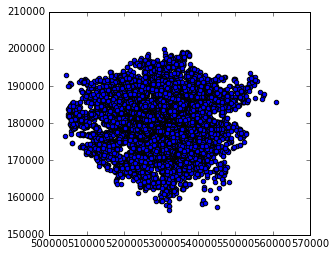

In [13]:
from shapely.geometry import Point

lsoa2 = gpd.read_file(os.path.join('LSOA','LSOA_2011_London_gen_MHW.shp'))
lsoa2.crs = {'init': u'epsg:27700'}

df = pd.read_csv(
    'http://data.insideairbnb.com/united-kingdom/england/london/2017-03-04/visualisations/listings.csv',
    low_memory=False) # The 'low memory' option means pandas doesn't guess data types
print("Data frame shape: " + str(df.shape)) # What is the shape of the data?

geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
df.drop(['longitude', 'latitude'], axis=1, inplace=True)
crs = {'init': 'epsg:4326'}
airbnb = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
airbnb = airbnb.to_crs({'init': 'epsg:27700'})
airbnb.plot()
del(df)

In [14]:
df = gpd.sjoin(airbnb, lsoa2, how="inner", op='within')
df = df[df.columns[0:17]]
df['Multiple Location Host'] = df.calculated_host_listings_count >= 3
df.drop(['index_right','geometry','neighbourhood_group',
         'id','name','host_name','neighbourhood',
         'last_review','calculated_host_listings_count',
         'reviews_per_month', 'availability_365'
        ], axis=1, inplace=True)

In [15]:
df.columns

Index([               u'host_id',              u'room_type',
                        u'price',         u'minimum_nights',
            u'number_of_reviews',               u'LSOA11CD',
       u'Multiple Location Host'],
      dtype='object')

### Price Data

In [16]:
f = {
    'price':['sum','mean','median'],
}
airbnbg = df.groupby(['LSOA11CD']).agg(f)
airbnbg = airbnbg.price.reset_index().set_index('LSOA11CD').rename(columns=lambda x: x.title() + " Price")
lsoa = pd.merge(lsoa, airbnbg, how='left', left_on='LSOA11CD', right_index=True)

In [17]:
airbnbg = df[['LSOA11CD','room_type']].groupby(['LSOA11CD','room_type']).size().reset_index(name='counts')
airbnbg = airbnbg.pivot(index='LSOA11CD', columns='room_type', values='counts').fillna(0)
lsoa = pd.merge(lsoa, airbnbg, how='left', left_on='LSOA11CD', right_index=True)

In [18]:
airbnbg = df[['LSOA11CD','Multiple Location Host']].groupby(['LSOA11CD','Multiple Location Host']).size().reset_index(name='counts')
airbnbg = airbnbg.pivot(index='LSOA11CD', columns='Multiple Location Host', values='counts').fillna(0).rename(columns = {True:'Multiple Location Host', False:'Small Host'})
lsoa = pd.merge(lsoa, airbnbg, how='left', left_on='LSOA11CD', right_index=True)
lsoa['Property Count'] = lsoa['Multiple Location Host'] + lsoa['Small Host']

## Wrapping Up

Save the final output for use by students.

In [19]:
lsoa['Area'] = lsoa.geometry.area
lsoa = lsoa.fillna(0)
lsoa.columns

Index([                                     u'LSOA11CD',
                                            u'LSOA11NM',
                                            u'MSOA11CD',
                                            u'MSOA11NM',
                                             u'LAD11CD',
                                             u'LAD11NM',
                                             u'RGN11CD',
                                             u'RGN11NM',
                                            u'USUALRES',
                                            u'HHOLDRES',
                                           u'COMESTRES',
                                              u'POPDEN',
                                              u'HHOLDS',
                                           u'AVHHOLDSZ',
                                            u'geometry',
                  u'Area that is Designated Greenspace',
                    u'Area within 250m of M or A Roads',
                               

In [20]:
lsoa.sample(3)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Sum Price,Mean Price,Median Price,Entire home/apt,Private room,Shared room,Small Host,Multiple Location Host,Property Count,Area
1157,E01001176,Croydon 011C,E02000204,Croydon 011,E09000008,Croydon,E12000007,London,1902,1899,...,65.0,32.500,32.5,1.0,1.0,0.0,2.0,0.0,2.0,252948.226746
3224,E01003297,Lewisham 003A,E02000655,Lewisham 003,E09000023,Lewisham,E12000007,London,1538,1538,...,136.0,68.000,68.0,2.0,0.0,0.0,2.0,0.0,2.0,370591.180400
4322,E01004432,Waltham Forest 023D,E02000917,Waltham Forest 023,E09000031,Waltham Forest,E12000007,London,1755,1755,...,399.0,49.875,46.5,3.0,4.0,1.0,4.0,4.0,8.0,185827.555412


In [21]:
lsoa.to_csv(os.path.join('Data','LSOA Data.csv.gz'), index=False, compression='gzip')